In [4]:
import turicreate as tc
import seaborn as sns
import matplotlib.pyplot as plt

In [201]:
%matplotlib inline
sns.set()
sns.set_palette("husl")
plt.style.use("seaborn-notebook")

Requires Python >= 3.6 environment


___
# Sentiment Analysis
### Logistic Classifiers vs RNN

In this notebook, we take some Amazon product review data on baby products, and compare three diferent methods of sentiment analysis:
- 1. Logistic classifier using all words in the reviews
- 2. Logistic classifier using only selected words in the reviews
- 3. Recurrent Neural Network model

## 1. Data read & explore

In [237]:
products = tc.SFrame('amazon_baby.gl/')

In [8]:
products.head(4)

name,review,rating
Planetwise Flannel Wipes,"These flannel wipes areOK, but in my opinion ...",3.0
Planetwise Wipe Pouch,it came early and was notdisappointed. i love ...,5.0
Annas Dream Full Quiltwith 2 Shams ...,Very soft and comfortableand warmer than it ...,5.0
Stop Pacifier Suckingwithout tears with ...,This is a product wellworth the purchase. I ...,5.0


In [248]:
# add another column: 'word_count' - will tokenise the reviews for logistic classifer
products['word_count'] = tc.text_analytics.count_words(products['review'])

In [7]:
products.head(4)

name,review,rating,word_count
Planetwise Flannel Wipes,"These flannel wipes areOK, but in my opinion ...",3.0,"{'handles': 1,'stripping': 1, 'while': ..."
Planetwise Wipe Pouch,it came early and was notdisappointed. i love ...,5.0,"{'recommend': 1, 'moist':1, 'osocozy': 1, 'keps': ..."
Annas Dream Full Quiltwith 2 Shams ...,Very soft and comfortableand warmer than it ...,5.0,"{'quilt': 1,'comfortable': 1, 'bed': ..."
Stop Pacifier Suckingwithout tears with ...,This is a product wellworth the purchase. I ...,5.0,"{'tool': 1, 'clever': 1,'little': 1, 'loves': 1, ..."


## Let's take a look at the distribution of product ratings:

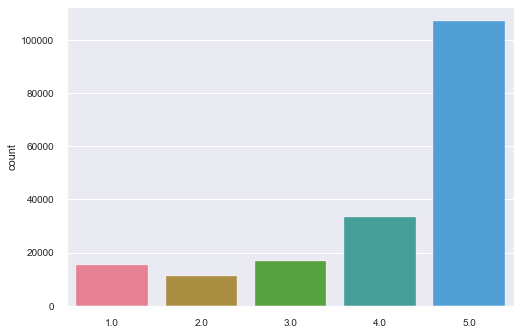

In [246]:
sns.countplot(np.array(products['rating']))
plt.show()

Overwhelmingly positive ratings

## Examining the reviews for most-sold product:  'Vulli Sophie the Giraffe Teether'

In [249]:
giraffe_reviews = products[products['name'] == 'Vulli Sophie the Giraffe Teether']
len(giraffe_reviews)

785

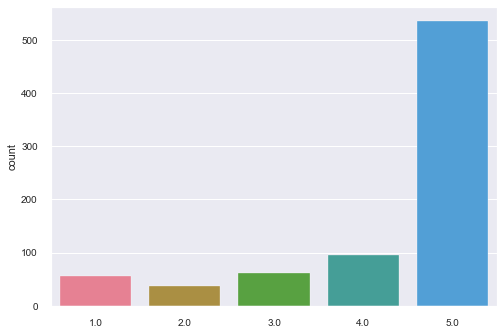

In [278]:
sns.countplot(np.array(giraffe_reviews['rating']))
plt.show()

___
# 2. Building a sentiment classifier

## Let's define what is a positive and a negative sentiment

We will ignore all reviews with rating = 3, since they tend to have a neutral sentiment.  Reviews with a rating of 4 or higher will be considered positive, while the ones with rating of 2 or lower will have a negative sentiment.   

In [254]:
# remove products with rating == 3
products = products[products['rating'] != 3]
len(products['name'])

166752

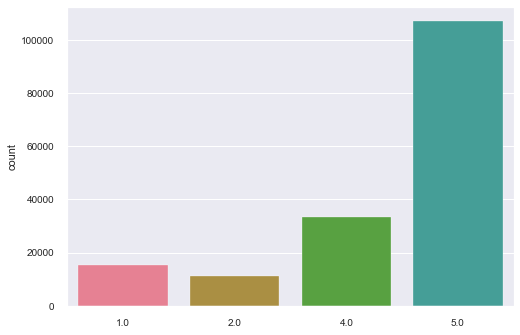

In [256]:
sns.countplot(np.array(products['rating']))
plt.show()

No 3 star product reviews 

## Adding a new binary column 'sentiment'  
Takes value 1 if rating is 4 or 5  
Takes value 0 if rating is 1 or 2

In [258]:
# positive sentiment = 4* or 5* reviews
products['sentiment'] = products['rating'] >= 4

In [31]:
products.head(4)

name,review,rating,word_count,sentiment
Planetwise Wipe Pouch,it came early and was notdisappointed. i love ...,5.0,"{'recommend': 1, 'moist':1, 'osocozy': 1, 'keps': ...",1
Annas Dream Full Quiltwith 2 Shams ...,Very soft and comfortableand warmer than it ...,5.0,"{'quilt': 1,'comfortable': 1, 'bed': ...",1
Stop Pacifier Suckingwithout tears with ...,This is a product wellworth the purchase. I ...,5.0,"{'tool': 1, 'clever': 1,'little': 1, 'loves': 1, ...",1
Stop Pacifier Suckingwithout tears with ...,All of my kids have criednon-stop when I tried to ...,5.0,"{'rock': 1, 'many': 1,'headaches': 1, 'soo' ...",1


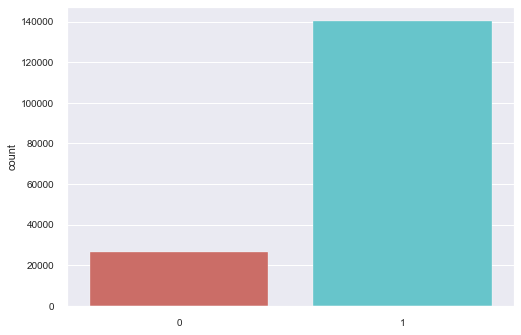

In [280]:
sns.countplot(np.array(products['sentiment']), palette='hls')
plt.show()

Consistent with ratings: vast majority of sentiment is positive

___
# 3. MODEL 1: Logistic Classifier
First, we will train a Logistic Classifier on the data and evaluate it's performance

In [281]:
# split data into a traning (80%) and testing (20%) data sets
train_data, test_data = products.random_split(.8, seed=0) 

In [282]:
sentiment_model = tc.logistic_classifier.create(train_data,
                                                target='sentiment',
                                                features=['word_count'],
                                                validation_set=test_data)

Logistic regression:

--------------------------------------------------------

Number of examples          : 133448

Number of classes           : 2

Number of feature columns   : 1

Number of unpacked features : 57356

Number of coefficients      : 57357

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 0         | 4        | 0.250000  | 2.585375     | 0.841421          | 0.840019            |

| 1         | 9        | 3.250000  | 5.131030     | 0.931359          | 0.911362            |

| 2         | 11       | 2.669978  | 5.867733     | 0.938650          | 0.916466            |

| 3         | 12       | 2.669978  | 6.390802     | 0.927417          | 0.901814            |

| 4         | 14       | 1.326072  | 7.138122     | 0.945200          | 0.918088            |

| 9         | 20       | 1.326072  | 9.681095     | 0.977654          | 0.917698            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

## Evaluate the sentiment model

In [283]:
logRegsRes = sentiment_model.evaluate(test_data, metric='roc_curve')
logRegsRes

{'roc_curve': Columns:
 	threshold	float
 	fpr	float
 	tpr	float
 	p	int
 	n	int
 
 Rows: 100001
 
 Data:
 +-----------+--------------------+--------------------+-------+------+
 | threshold |        fpr         |        tpr         |   p   |  n   |
 +-----------+--------------------+--------------------+-------+------+
 |    0.0    |        1.0         |        1.0         | 27976 | 5328 |
 |   1e-05   | 0.847972972972973  | 0.9975693451529882 | 27976 | 5328 |
 |   2e-05   | 0.829954954954955  | 0.9971761509865599 | 27976 | 5328 |
 |   3e-05   | 0.818506006006006  | 0.9969616814412353 | 27976 | 5328 |
 |   4e-05   | 0.8109984984984985 | 0.9967472118959108 | 27976 | 5328 |
 |   5e-05   | 0.8057432432432432 | 0.9966042321990277 | 27976 | 5328 |
 |   6e-05   | 0.7991741741741741 | 0.9962825278810409 | 27976 | 5328 |
 |   7e-05   | 0.7952327327327328 | 0.9961752931083786 | 27976 | 5328 |
 |   8e-05   | 0.7920420420420421 | 0.9961038032599371 | 27976 | 5328 |
 |   9e-05   | 0.7882882882882

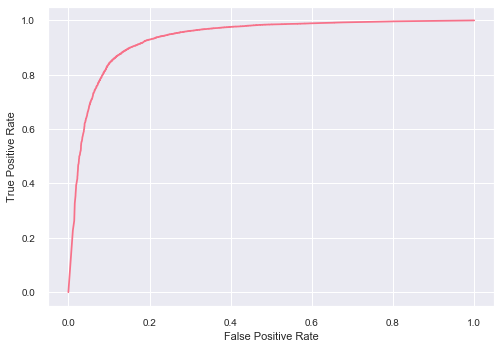

In [284]:
plt.plot(logRegsRes['roc_curve']['fpr'], logRegsRes['roc_curve']['tpr'])
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.show()

___
# 4. Applying the learned model to understand sentiment for Giraffe

In [285]:
# get predicted scores
giraffe_reviews['predicted_sentiment'] = sentiment_model.predict(giraffe_reviews, output_type='probability')

### Sort the reviews based on the predicted sentiment and explore, higher values on top

In [286]:
giraffe_reviews = giraffe_reviews.sort('predicted_sentiment', ascending=False)
giraffe_reviews.head(4)

name,review,rating,word_count,predicted_sentiment
Vulli Sophie the GiraffeTeether ...,I'll be honest...I boughtthis toy because all the ...,4.0,"{'explore': 1,'adventures': 1, 'many': ...",1.0
Vulli Sophie the GiraffeTeether ...,As a mother of 16monthold twins; I bought ...,5.0,"{'use': 1, 'get': 1,'will': 1, 'where': 1, ...",1.0
Vulli Sophie the GiraffeTeether ...,"Sophie, oh Sophie, yourtime has come. My ...",5.0,"{'09': 1, '11': 1,'recommended': 1, 'la': ...",1.0
Vulli Sophie the GiraffeTeether ...,We got this littlegiraffe as a gift from a ...,5.0,"{'parents': 1,'recommend': 1, 'happy': ...",0.9999999999998377


### Plotting product rating against predicted sentiment

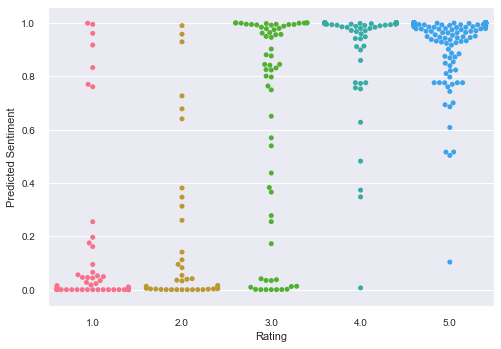

In [290]:
sns.swarmplot(x=list(giraffe_reviews['rating']),
              y=giraffe_reviews['predicted_sentiment'])
plt.xlabel('Rating')
plt.ylabel('Predicted Sentiment')
plt.show()

This plot shows that the classifier is working well, though we can see that there are more false positives than false negatives

___
___   
   
# MODEL 2
This part of the notebook creates a second logistic classifier, using a selection of 11 words

## 1. Create column with count for each selected_word

In [294]:
def selected_word_count(word_count, w=word):
    if word in word_count:
        return word_count[word]
    return 0

In [295]:
selected_words = ['awesome', 'great', 'fantastic', 'amazing', 'love',
                  'horrible', 'bad', 'terrible', 'awful', 'wow', 'hate']
for word in selected_words:
    products[word] = products['word_count'].apply(selected_word_count)

In [296]:
products.head(4)

Columns:
	name	str
	review	str
	rating	float
	word_count	dict
	sentiment	int
	awesome	int
	great	int
	fantastic	int
	amazing	int
	love	int
	horrible	int
	bad	int
	terrible	int
	awful	int
	wow	int
	hate	int

Rows: 4

Data:
+-------------------------------+-------------------------------+--------+
|              name             |             review            | rating |
+-------------------------------+-------------------------------+--------+
|     Planetwise Wipe Pouch     | it came early and was not ... |  5.0   |
| Annas Dream Full Quilt wit... | Very soft and comfortable ... |  5.0   |
| Stop Pacifier Sucking with... | This is a product well wor... |  5.0   |
| Stop Pacifier Sucking with... | All of my kids have cried ... |  5.0   |
+-------------------------------+-------------------------------+--------+
+-------------------------------+-----------+---------+-------+-----------+---------+
|           word_count          | sentiment | awesome | great | fantastic | amazing |
+-------------------------------+-----------+---------+-------+-----------+---------+
| {'recommend': 1, 'moist': ... |     1     |    0    |   0   |     0     |    0    |
| {'quilt': 1, 'comfortable'... |     1     |    0    |   0   |     0     |    0    |
| {'tool': 1, 'clever': 1, '... |     1     |    0    |   0   |     0     |    0    |
| {'rock': 1, 'many': 1, 'he... |     1     |    0    |   1   |     0     |    0    |
+-------------------------------+-----------+---------+-------+-----------+---------+
+------+----------+-----+----------+-------+-----+------+
| love | horrible | bad | terrible | awful | wow | hate |
+------+----------+-----+----------+-------+-----+------+
|  1   |    0     |  0  |    0     |   0   |  0  |  0   |
|  0   |    0     |  0  |    0     |   0   |  0  |  0   |
|  2   |    0     |  0  |    0     |   0   |  0  |  0   |
|  1   |    0     |  0  |    0     |   0   |  0  |  0   |
+------+----------+-----+----------+-------+-----+------+
[4 rows x 16 columns]

## Which of the selected words are used most often?

In [76]:
# This cell takes about 20secs to run
word_sum_dict = {word: products[word].sum() for word in selected_words}
word_sum_dict

{'awesome': 3892,
 'great': 55791,
 'fantastic': 1664,
 'amazing': 2628,
 'love': 41994,
 'horrible': 1110,
 'bad': 4183,
 'terrible': 1146,
 'awful': 687,
 'wow': 425,
 'hate': 1107}

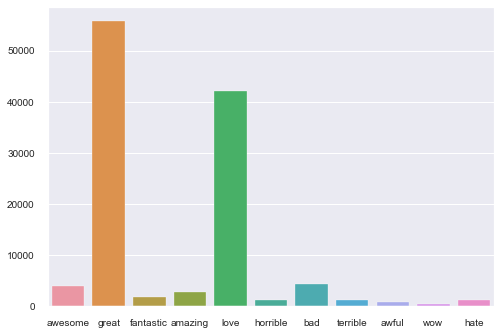

In [77]:
y_vals = [val for val in word_sum_dict.values()]
sns.barplot(x=selected_words, y=y_vals)
plt.show()

In [78]:
max_word = max(word_sum_dict, key=word_sum_dict.get)
min_word = min(word_sum_dict, key=word_sum_dict.get)
print(f"Most used word:   {max_word}  ({word_sum_dict[max_word]})\n"
      f"Least used word:  {min_word}  ({word_sum_dict[min_word]})")

Most used word:   great  (55791)
Least used word:  wow  (425)


___     
  
# 2. MODEL 2 - Logistic Classifer with only selected_words

In [297]:
train_data, test_data = products.random_split(.8, seed=0)

In [298]:
selected_words_model = tc.logistic_classifier.create(train_data,
                                                     target='sentiment',
                                                     features=selected_words,
                                                     validation_set=test_data)

Logistic regression:

--------------------------------------------------------

Number of examples          : 133448

Number of classes           : 2

Number of feature columns   : 11

Number of unpacked features : 11

Number of coefficients      : 12

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+--------------+-------------------+---------------------+

| 1         | 2        | 0.374070     | 0.847401          | 0.845874            |

| 2         | 3        | 0.572912     | 0.847514          | 0.846085            |

| 3         | 4        | 0.768019     | 0.847626          | 0.846115            |

| 4         | 5        | 0.941794     | 0.847708          | 0.846385            |

| 5         | 6        | 1.119975     | 0.847708          | 0.846385            |

| 6         | 7        | 1.313107     | 0.847708          | 0.846385            |

+-----------+----------+--------------+-------------------+---------------------+

SUCCESS: Optimal solution found.

In [299]:
slctd_words_model_coef = selected_words_model.coefficients.sort('value')
slctd_words_model_coef.print_rows(num_rows=12)

+-------------+-------+-------+----------------------+----------------------+
|     name    | index | class |        value         |        stderr        |
+-------------+-------+-------+----------------------+----------------------+
|   horrible  |  None |   1   |  -2.251335236759102  | 0.08020249388788425  |
|   terrible  |  None |   1   | -2.2236614360851346  | 0.07731736203785744  |
|    awful    |  None |   1   | -2.0529082040313598  | 0.10099735435259247  |
|     hate    |  None |   1   | -1.3484407222463202  | 0.07715698604297323  |
|     bad     |  None |   1   | -0.9914778800650664  | 0.03848428664699063  |
|     wow     |  None |   1   | -0.00953823606768843 | 0.16046411224711649  |
|    great    |  None |   1   |  0.8630655001196439  | 0.018955052444376685 |
|  fantastic  |  None |   1   |   0.88580475688142   | 0.11167591293399651  |
|   amazing   |  None |   1   |  1.100093311366018   |  0.0995477626046598  |
|   awesome   |  None |   1   |  1.133534666034134   | 0.0839964

## Plotting selected_word weights

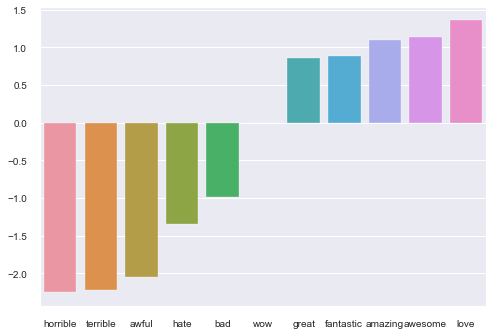

In [313]:
# removing (intercept) to plot the different word weights
names = list(slctd_words_model_coef['name'])
values = list(slctd_words_model_coef['value'])
x_vals = names[:10] + names[-1:]
y_vals = values[:10] + values[-1:]
sns.barplot(x=x_vals, y=y_vals)
plt.show()

___
## 3. Comparing the accuracy of the two different logistic classifiers:

In [144]:
selected_words_model.evaluate(test_data, metric='confusion_matrix')

{'confusion_matrix': Columns:
 	target_label	int
 	predicted_label	int
 	count	int
 
 Rows: 4
 
 Data:
 +--------------+-----------------+-------+
 | target_label | predicted_label | count |
 +--------------+-----------------+-------+
 |      0       |        0        |  371  |
 |      0       |        1        |  4957 |
 |      1       |        1        | 27817 |
 |      1       |        0        |  159  |
 +--------------+-----------------+-------+
 [4 rows x 3 columns]}

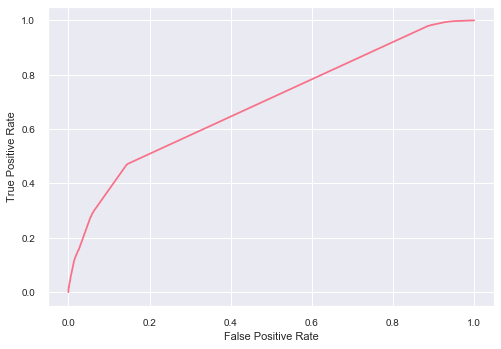

In [314]:
# Plotting the roc_curve
x = selected_words_model.evaluate(test_data, metric="roc_curve")
plt.plot(x['roc_curve']['fpr'], x['roc_curve']['tpr'])
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.show()

This ROC clearly displays a much smaller AUC (Area Under Curve) than the previous model, indicating it is a poorer model

### Comparing model accuracies

In [347]:
slctd_words_accuracy = selected_words_model.evaluate(test_data, metric='accuracy')
slctd_words_accuracy

{'accuracy': 0.8463848186404036}

In [348]:
all_words_accuracy = sentiment_model.evaluate(test_data, metric='accuracy')
all_words_accuracy

{'accuracy': 0.9176975738650012}

### Majority class classifier accuracy

In [351]:
high_sent = len(products[products['rating'] >= 4])
majority_class_clas = high_sent / len(products['rating'])
majority_class_clas

0.8411233448474381

### Comparing accuracy of the 3 models

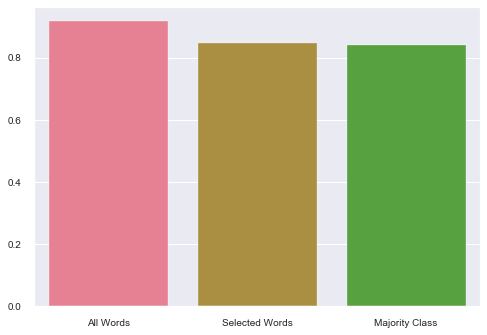

In [149]:
sns.barplot(x=["All Words", "Selected Words", "Majority Class"],
            y=[all_words_accuracy['accuracy'], slctd_words_accuracy['accuracy'], majority_class_clas])
plt.show()

- The model using all words has the highest accuracy
- The model using selected words only performs 0.53% better than the majority class classifier (just assuming all reviews are positive)

___
___
# Model 3 - RNN
 - We will now train a Recurrent Neural Net model on the data, and compare it's performance to the models above
 - Due to the computationally demanding nature of this task, a number of limitations were introduced to this model:
     - Using random 10% subset of the original data set
     - Using only 500 most frequent words (max_features)
     - Batch size = 128

___

In [1]:
import numpy as np
import pandas as pd 

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

In [315]:
np.random.seed(4404)

## 1. Reformatting the data for use with Keras

In [25]:
products.head(4)

name,review,rating,word_count,sentiment
Planetwise Wipe Pouch,it came early and was notdisappointed. i love ...,5.0,"{'recommend': 1, 'moist':1, 'osocozy': 1, 'keps': ...",1
Annas Dream Full Quiltwith 2 Shams ...,Very soft and comfortableand warmer than it ...,5.0,"{'quilt': 1,'comfortable': 1, 'bed': ...",1
Stop Pacifier Suckingwithout tears with ...,This is a product wellworth the purchase. I ...,5.0,"{'tool': 1, 'clever': 1,'little': 1, 'loves': 1, ...",1
Stop Pacifier Suckingwithout tears with ...,All of my kids have criednon-stop when I tried to ...,5.0,"{'rock': 1, 'many': 1,'headaches': 1, 'soo' ...",1


In [26]:
products_for_keras = products[['review', 'sentiment']]

In [27]:
products_for_keras.head(4)

review,sentiment
it came early and was notdisappointed. i love ...,1
Very soft and comfortableand warmer than it ...,1
This is a product wellworth the purchase. I ...,1
All of my kids have criednon-stop when I tried to ...,1


In [28]:
baby_data = products_for_keras.to_numpy()

### Taking random 10% subset of the data:

In [29]:
ten_perc_idx = round(len(baby_data) * 0.1)
np.random.shuffle(baby_data)
baby_data_subset = baby_data[0:ten_perc_idx, :]
num_reviews = len(baby_data_subset)
num_reviews

16675

In [30]:
XY = baby_data_subset[:,[0, 1]]
print(XY[0])

['Purchased several of these to have on hand as gifts.  I take them to my local embroiderer and have them personalized.'
 '1']


___
## 2. Tokenising the reviews

In [51]:
max_features = 500  # in keras, this defaults to the top 500 most frequent words
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(XY[:,0])  # 0 is the index of reviews in XY
X = tokenizer.texts_to_sequences(XY[:,0])
X = pad_sequences(X)  # automatically pads to longest sequence

In [52]:
np.amax(X)  # checking vocab size

499

In [53]:
len(X[0])  # checking padding

2112

In [54]:
Y = pd.get_dummies(XY[:,1])  # converts categorical variable into dummy/indicator variables
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(13340, 2112) (13340, 2)
(3335, 2112) (3335, 2)


___
## 3. MODEL 3 - RNN
- The cells in this section were run in Google Colab (GPU)
- The model is created, trained, then saved for later use
- For viewing, do not run these cells

In [41]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())

W0827 21:10:57.510032 4455728576 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2112, 128)         64000     
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 2112, 128)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 394       
Total params: 319,194
Trainable params: 319,194
Non-trainable params: 0
_________________________________________________________________
None


In [20]:
batch_size = 128
model.fit(X_train, Y_train, epochs = 5, batch_size=batch_size, verbose = 2)

Epoch 1/5
 - 487s - loss: 0.3966 - acc: 0.8448
Epoch 2/5
 - 485s - loss: 0.2942 - acc: 0.8773
Epoch 3/5
 - 486s - loss: 0.2634 - acc: 0.8903
Epoch 4/5
 - 488s - loss: 0.2793 - acc: 0.8839
Epoch 5/5
 - 486s - loss: 0.2609 - acc: 0.8912


## Saving Model:

In [23]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


___
## 4. Evaluating the RNN model

### Loading model:

In [55]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

loaded_model.load_weights("model.h5")
print("Loaded model from disk")

# recompiling to test on test data and evalutation
loaded_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Loaded model from disk


### Evaluating model:

In [352]:
rnn_accuracy = loaded_model.evaluate(X_test, Y_test, verbose=2)
print(f"Accuracy: {accuracy[1]*100:.2f}%")

Accuracy: 88.55%


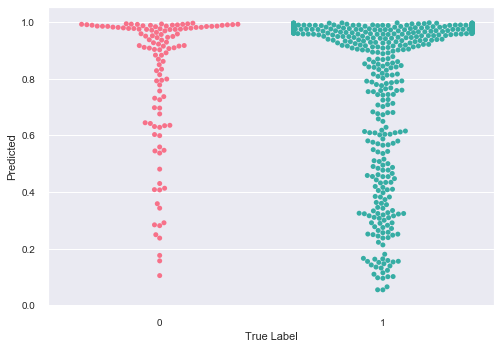

In [344]:
# Plotting distribution of predicted labels against true labels
Y_test_prob = loaded_model.predict(X_test)
sns.swarmplot(x=Y_test['1'], y=Y_test_prob[:,1], palette='husl')
plt.xlabel('True Label')
plt.ylabel('Predicted')
plt.show()

Model seems to predict positive respones better than negative ones, affirmed below:

In [61]:
prdct_Y_test = loaded_model.predict_classes(X_test)

In [332]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test['1'], prdct_Y_test)
true_pos = cm[1,1]
true_neg = cm[0,0]
false_pos = cm[0,1]
false_neg = cm[1,0]
print(f"Confusion matrix:\n{cm}\n")
true_pos_precision = (true_pos / (false_pos + true_pos)) * 100
true_neg_precision = (true_neg / (false_neg + true_neg)) * 100
print(f"Positive Precision: {true_pos_precision:.2f}%")
print(f"Negative Precision: {true_neg_precision:.2f}%")

Confusion matrix:
[[ 328  222]
 [ 160 2625]]

Positive Precision: 92.20%
Negative Precision: 67.21%


- Our model predicts positive sentiment much better than it predicts negative sentiment.
- This is unsurprising, as we saw earlier that the vast majority of the data it trained on contains positive reviews.

In [213]:
from sklearn.metrics import classification_report
print(classification_report(Y_test['1'], prdct_Y_test))

              precision    recall  f1-score   support

           0       0.67      0.60      0.63       550
           1       0.92      0.94      0.93      2785

    accuracy                           0.89      3335
   macro avg       0.80      0.77      0.78      3335
weighted avg       0.88      0.89      0.88      3335



Positive f1-score: 0.93  
Negative f1-score: 0.63

___
___
# Conclusions and Comparions

### First, lets look at the accuracy of the 3 models we have created, and the majority class classifier:


Logistic Classifer - All Words:       91.77%
Logistic Classifer - Selected Words:  84.64%
Reccurent Neural Net - 500 Words:     88.55%
Majority Class Classifer:             84.11%



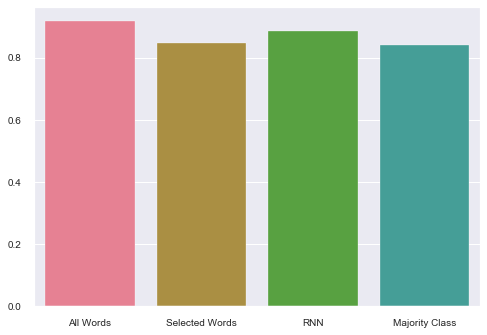

In [360]:
print(f"\n{'Logistic Classifer - All Words:':<37} {all_words_accuracy['accuracy']*100:.2f}%")
print(f"{'Logistic Classifer - Selected Words:':<37} {slctd_words_accuracy['accuracy']*100:.2f}%")
print(f"{'Reccurent Neural Net - 500 Words:':<37} {rnn_accuracy[1]*100:.2f}%")
print(f"{'Majority Class Classifer:':<37} {majority_class_clas*100:.2f}%\n")

sns.barplot(x=["All Words", "Selected Words", "RNN", "Majority Class"],
            y=[all_words_accuracy['accuracy'], slctd_words_accuracy['accuracy'],
               rnn_accuracy[1], majority_class_clas])
plt.show()

We can see that Model 1, the Logistic Classifier that used all the words in the reviews had the highest accuracy, followed by our RNN with top 500 words, then the Logistic Classifier using 11 selected words, and finally the Majority Class Classifier.

### Which model should we use?

Firstly, all three of our models out perform the Majority Class Classifier, so we safely can rule that model out.
Secondly, we can directly compare the two different Logistic Classifier models, noting that Model 1 (All Words) vastly outperforms Model 2 (Selected Words).
So, we are left with Model 1 and Model 3: our RNN model.  

Comparing these two models, though, comes with some challenges. Most notably, the two models are training and testing on different data: Model 1 on the entire set, Model 3 on a random 10% subset. So rather than comparing these two models directly, let's analyse how we could have improved the RNN with more computation power and time, to accurately compare to the Logistic Classifier:  

RNN Improvements:
- Train on all the data, rather than a subset
    - While we can relatively safely assume that our random sample is representitive of the population (Central Limit Theorem), it is highly likely that training the model on the entire dataset would produce a more accurate and precise classifier
- Increased number of epochs
    - Whilst training our RNN model, we could see a steady trend of loss decreasing and accuracy increasing
    - Continued training would likely have resulted in a better model
- Increased number of features (number of words in vocabulary dictionary)
    - In Model 2, we saw how just using a selection of words rather than the entire vocabulary affected our accuracy, and how analysing reviews that didn't contain these words gave poor results
    - In our model we selected only 500 words, which would likely have the a similar affect here
    - Also, as Keras' num_words=n paramater selects only the most frequent n words from the supplied text, it is likely that our vocabulary dictionary contains a large proportion of 'stop words' (eg. 'is', 'it', 'that'). These words clearly have less of an affect on sentiment (when considered as a 1gram; singular word) than other less frequently appearing words (eg. 'happy', 'amazing', 'awful')  
    
    
What can be said in comparing these models though, is that the speed at which the Logistic Classifier trains is significantly quicker than the RNN:

### Time comparison:

In [408]:
model1_secs = round(sentiment_model.training_time, 2)
model3_secs = 487 + 485 + 485 + 488 + 486
model3_mins = round(model3_secs / 60, 2)
print("Logistic Classifier - All Words\n",
      "100% of dataset\n",
     f"Training time:  {model1_secs} seconds\n")
print("RNN Model - 500 Words\n",
      "10% of dataset\n",
     f"Training time:  {model3_mins} minutes")

model1_time_prop = round((model1_secs / model3_secs) * 100, 3)
print(f"\nmodel1_time_prop: {model1_time_prop}%")

Logistic Classifier - All Words
 100% of dataset
 Training time:  6.51 seconds

RNN Model - 500 Words
 10% of dataset
 Training time:  40.52 minutes

model1_time_prop: 0.268%


### Vocab size comparison:

In [412]:
model1_vocab_size = 57356  # Taken from Model 1's 'Unpacked Features' metric in Logistic Regression summary
model1_vocab_prop = round((model1_vocab_size / 500), 3)
print(f"model1_vocab_prop: {model1_vocab_prop}")

model1_vocab_prop: 114.712


### Results:

We can see that Model 1 trained with a vocabulary size 114x larger than that of the RNN model, in 0.268% of the time. These results are extremely significant, and would play a huge part in determining whether or not to go ahead with training an RNN model.

### Personal Conclusion:

The decision to use a Logistic Classifier model or Recurrent Neural Net depends on a multitude of external factors:
- dataset size
- computational power
- time for training
- stability of training environment (note: Google Colab times out frequently whilst training large neural nets)

But, inferred from the results in this assignment, if asked for a recommendation on which model to use for sentiment analysis I would certainly recommend starting with a Logistic Classifier using the entire vocabulary, due to its speed and simplicity. If resources were permitting and more accurate results desired, an RNN Model could then be trained and compared.

___
___
## References
- https://www.coursera.org/learn/ml-foundations/supplement/phb1M/reading-analyzing-product-sentiment-assignment
- https://apple.github.io/turicreate/docs/api/
- https://machinelearningmastery.com/save-load-keras-deep-learning-models/
- https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/
- https://www.kaggle.com/ngyptr/lstm-sentiment-analysis-keras